# Necessary Imports

In [1]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import seaborn as sns
import pathlib
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Data Loading & Train Test Split

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/axialdb/Axial",
    validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=[180, 180],
    batch_size=16,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/axialdb/Axial",
    validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=[180, 180],
    batch_size=16 ,
)

Found 5154 files belonging to 3 classes.
Using 3608 files for training.
Found 5154 files belonging to 3 classes.
Using 1546 files for validation.


In [3]:
Num_Images = []
classnames = train_ds.class_names
len(classnames),train_ds.class_names
for label in classnames:
    dir_name = "/kaggle/input/axialdb/Axial" +'/'+ label 
    Num_Images.append(len([name for name in os.listdir(dir_name)]))
    
Num_Images,classnames

([1124, 2590, 1440], ['AD', 'CI', 'CN'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


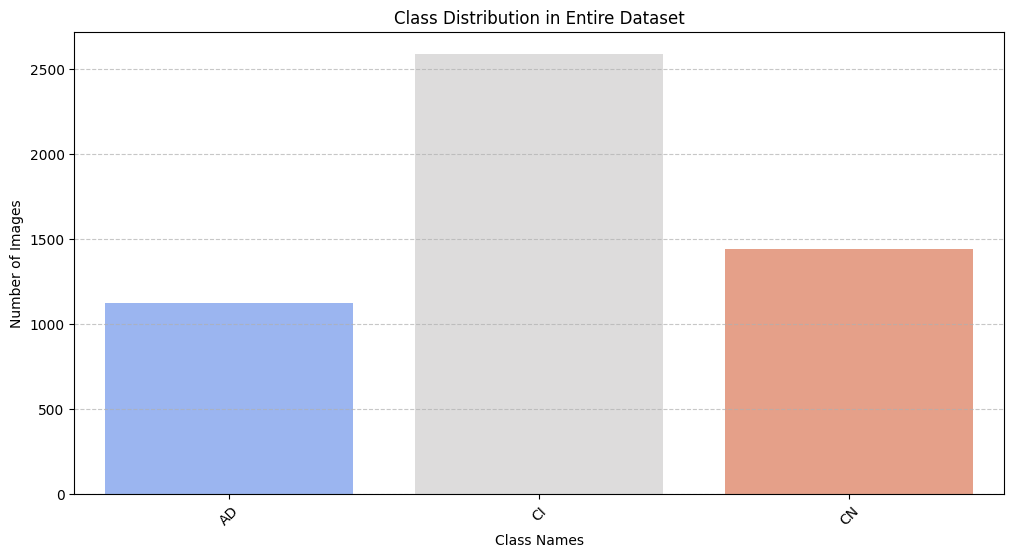

In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset root directory
dataset_root = "/kaggle/input/axialdb/Axial"

# Get all class names (assuming class folders exist in dataset_root)
classnames = sorted(os.listdir(dataset_root))  # Sorting ensures consistent order

# Dictionary to store image counts per class
class_distribution = {classname: 0 for classname in classnames}

# Loop through all class directories and count images
for label in classnames:
    class_dir = os.path.join(dataset_root, label)
    
    # Count total images in the class directory
    num_images = len(os.listdir(class_dir))
    class_distribution[label] += num_images  # Store count

# Convert to lists for visualization
classnames_list = list(class_distribution.keys())
num_images_list = list(class_distribution.values())

# Plot the Class Distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=classnames_list, y=num_images_list, palette="coolwarm")

plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.title("Class Distribution in Entire Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Optional: Add a grid for clarity
plt.show()


In [5]:
IMG_DIM = 180
IMAGE_SHAPE = [180, 180]
INPUT_SIZE = (IMG_DIM, IMG_DIM)
ZOOM_RANGE = [.99, 1.01]
BRIGHTNESS_ADJUST = [0.8, 1.2]
HORIZONTAL_FLIP = True
PIXEL_FILL_MODE = "constant"
CHANNEL_ORDER = "channels_last"
DATASET_PATH = "/kaggle/input/axialdb/Axial"

data_generator = IDG(
    rescale=1./255, 
    brightness_range=BRIGHTNESS_ADJUST, 
    zoom_range=ZOOM_RANGE, 
    data_format=CHANNEL_ORDER, 
    fill_mode=PIXEL_FILL_MODE, 
    horizontal_flip=HORIZONTAL_FLIP
)

training_data_loader = data_generator.flow_from_directory(
    directory=DATASET_PATH, 
    target_size=INPUT_SIZE, 
    batch_size=8000, 
    shuffle=False
)

Found 5154 images belonging to 3 classes.


In [6]:
train_data, train_labels = next(training_data_loader)

In [7]:
print(train_data.shape, train_labels.shape)

(5154, 180, 180, 3) (5154, 3)


In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.3, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.3, random_state=42)

# Define The Model Architecture 

In [9]:
# Load Pretrained ResNet50 Model
base = ResNet50(input_shape=(180, 180, 3), weights='imagenet', include_top=False)

# Freeze all layers in ResNet50
for layer in base.layers:
    layer.trainable = False

# Add custom classification layers
x_base = Flatten()(base.output) 
prediction_base = Dense(3, activation='softmax')(x_base)

# Create VGG19 model
model_base = Model(inputs=base.input, outputs=prediction_base)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
model_base.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 186, 186, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 90, 90, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 90, 90, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 90, 90, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 92, 92, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 45, 45, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 45, 45, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 45, 45, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 45, 45, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 45, 45, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 45, 45, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 45, 45, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 45, 45, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 45, 45, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,808,899 (90.82 MB)

 Trainable params: 221,187 (864.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Callbacks for Training

In [11]:
# Compile the VGG19 model
model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Define Callbacks
checkpoint_base = ModelCheckpoint(filepath='base_model.weights.h5', save_best_only=True, save_weights_only=True)
lr_base = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='min')  # Changed mode to 'min'
early_stop_base = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


# Training The Model

In [12]:
# Train the model with callbacks
history_base = model_base.fit(
    train_data,train_labels, 
    epochs=20,validation_data = (val_data,val_labels),
    callbacks=[checkpoint_base, lr_base]
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 231ms/step - accuracy: 0.4254 - loss: 4.5145 - val_accuracy: 0.5023 - val_loss: 1.6575 - learning_rate: 0.0010
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.4523 - loss: 1.3582 - val_accuracy: 0.5669 - val_loss: 0.9360 - learning_rate: 0.0010
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.5054 - loss: 1.1168 - val_accuracy: 0.6233 - val_loss: 0.8835 - learning_rate: 0.0010
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5161 - loss: 1.0859 - val_accuracy: 0.5411 - val_loss: 0.9516 - learning_rate: 0.0010
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5195 - loss: 1.1260
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5195 - loss: 1.1266 - val_accuracy: 0.5789 - val_loss: 1.5766 - learning_rate: 0.0010
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.5948 - loss: 1.0019 - val_ac

# Testing

In [13]:
test_scores = model_base.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.6194 - loss: 0.8352
Testing Accuracy: 63.35%


In [14]:
pred_labels1 = model_base.predict(test_data)

49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step


# Confusion Matrix & Classification Report

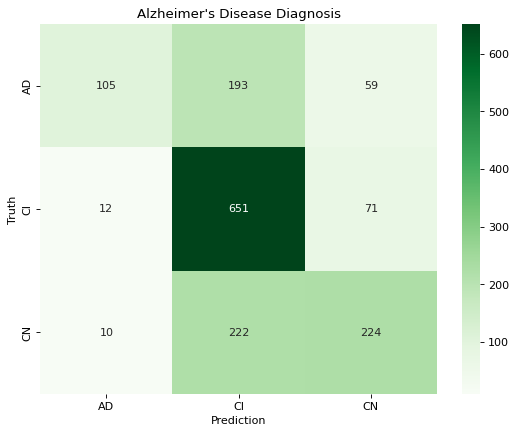

In [17]:
pred_ls = np.argmax(pred_labels1, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [16]:
print(classification_report(test_ls, pred_ls, target_names=classnames))

              precision    recall  f1-score   support

          AD       0.83      0.29      0.43       357
          CI       0.61      0.89      0.72       734
          CN       0.63      0.49      0.55       456

    accuracy                           0.63      1547
   macro avg       0.69      0.56      0.57      1547
weighted avg       0.67      0.63      0.61      1547

